## MIA FOR Finetuned LLM

### Environment Verification

Run this cell to verify your Python environment is set up correctly.

In [1]:
# Environment verification - run this cell to check your setup
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"\nIf the path shows '.venv', your environment is correctly configured!")

# Check if key packages are available (will error if not installed yet)
try:
    import torch
    import transformers
    import datasets
    print(f"\n✓ PyTorch version: {torch.__version__}")
    print(f"✓ Transformers version: {transformers.__version__}")
    print(f"✓ Datasets version: {datasets.__version__}")
    print(f"✓ CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"  GPU: {torch.cuda.get_device_name(0)}")
except ImportError as e:
    print(f"\n⚠ Some packages not installed yet. Run: pip install -r requirements.txt")
    print(f"  Error: {e}")

Python executable: /mnt/c/Users/adhit/OneDrive/Documents/CMU/Fall 2025/17-731 Foundations of Privacy/project/Project_phase1/.venv/bin/python
Python version: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]

If the path shows '.venv', your environment is correctly configured!

✓ PyTorch version: 2.8.0+cu128
✓ Transformers version: 4.56.2
✓ Datasets version: 4.1.1
✓ CUDA available: True
  GPU: NVIDIA GeForce RTX 5070 Ti

✓ PyTorch version: 2.8.0+cu128
✓ Transformers version: 4.56.2
✓ Datasets version: 4.1.1
✓ CUDA available: True
  GPU: NVIDIA GeForce RTX 5070 Ti


In [2]:
# update the downloading command as my LFS runs out so cannot directly clone model.safetensors
#%cd /content

#!rm -rf /content/Project_phase1

# skip LFS!!!: as my LFS bandwith run out
#!GIT_LFS_SKIP_SMUDGE=1 git clone https://github.com/2020pyfcrawl/Project_phase1.git

# download the model.safetensors: this enables faster download, you may also upload in colab but it's slower
# 1. download the model.safetensors from repo webpage
# 2. upload that into your google drive
# 3. copy link to share and replace the <...> with your link to download
# 4. run the command below
# !gdown --fuzzy <your google drive sharing path> -O /content/Project_phase1/models/gpt2_phase1/

#%cd /content/Project_phase1

!curl -L -o ./models/gpt2_phase1/model.safetensors "https://github.com/2020pyfcrawl/Project_phase1/raw/main/models/gpt2_phase1/model.safetensors"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  474M  100  474M    0     0  37.3M      0  0:00:12  0:00:12 --:--:-- 39.1M 0:00:02  0:00:14 35.4M 0:00:02  0:00:14 35.4M
100  474M  100  474M    0     0  37.3M      0  0:00:12  0:00:12 --:--:-- 39.1M


In [3]:
# check here, model.safetensors should be 475M, if not, delete it and re-download
!ls -lah ./models/gpt2_phase1/

total 480M
drwxrwxrwx 1 baktistr baktistr 4.0K Oct 19 22:10 .
drwxrwxrwx 1 baktistr baktistr 4.0K Oct 19 22:10 ..
-rwxrwxrwx 1 baktistr baktistr  899 Oct 19 22:08 config.json
-rwxrwxrwx 1 baktistr baktistr  154 Oct 19 22:08 generation_config.json
-rwxrwxrwx 1 baktistr baktistr 446K Oct 19 22:08 merges.txt
-rwxrwxrwx 1 baktistr baktistr 475M Oct 19 23:29 model.safetensors
-rwxrwxrwx 1 baktistr baktistr  131 Oct 19 22:08 special_tokens_map.json
-rwxrwxrwx 1 baktistr baktistr 3.4M Oct 19 22:08 tokenizer.json
-rwxrwxrwx 1 baktistr baktistr  507 Oct 19 22:08 tokenizer_config.json
-rwxrwxrwx 1 baktistr baktistr 780K Oct 19 22:08 vocab.json


### Variables and libraries

In [4]:
# install the required libraries if you have not done so (on you local machine or GPU server)
# you may not need to run this if you use colab as they are pre-installed, but you can always do it.
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os, math, argparse
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION", "1")

import torch
import numpy as np
from datasets import load_from_disk
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import roc_auc_score, roc_curve, auc as _auc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datasets import Dataset

In [6]:
# global variable, check the current position to adjust the path
target_model_dir = "./models/gpt2_phase1"
data_dir = "./data/wiki_json"
batch_size = 25

# you may change block size if you like (max length for the tokenizer below)
block_size = 256

### Data pre-processing

In [7]:
def tokenize_dataset(ds, tok, max_len):
    ds = ds.filter(lambda ex: ex.get("text", None) and len(ex["text"].strip()) > 0)

    def _map(ex):
        out = tok(ex["text"], truncation=True, padding=True, max_length=max_len, return_attention_mask=True)
        out["labels"] = out["input_ids"].copy()
        return out

    ds = ds.map(_map, batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

def _read_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

In [8]:
# for tests, you may only load a part of the data to save time while implementing,
# as running all 2000 samples on CPU may be slow, but not a problem here for GPU

# load test data
data_dir = Path(data_dir)
test_path = data_dir / "test.json"
test_items = _read_json(test_path)
ds_test = Dataset.from_dict({"text": test_items})

# tokenizer the test data
tokenizer = AutoTokenizer.from_pretrained(target_model_dir, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"

ds_test = tokenize_dataset(ds_test, tokenizer, block_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# you may load the model using the code:
# model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [9]:
model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)

In [10]:
# Verify GPU usage
print(f"Using device: {device}")
print(f"Model is on device: {next(model.parameters()).device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("⚠️ WARNING: GPU not available! Running on CPU (will be slower)")
    print("To use GPU in WSL2:")
    print("1. Install NVIDIA drivers on Windows")
    print("2. Install CUDA toolkit in WSL2")
    print("3. Reinstall PyTorch with CUDA support")

Using device: cuda
Model is on device: cuda:0
GPU Name: NVIDIA GeForce RTX 5070 Ti
GPU Memory Allocated: 0.48 GB
GPU Memory Reserved: 0.53 GB


### MIA

Implement your attack here!

In [11]:
# Attack 1: Loss-based Attack
# Uses CrossEntropyLoss - lower loss indicates the model is more confident (likely saw during training)
# We return negative loss so higher score = more likely member

@torch.no_grad()
def loss_based_attack(model, dataloader, device):
    """
    Compute average loss for each sample.
    Higher loss = less likely to be in training set (model struggles with it).
    Returns negative loss so higher score = more likely member.
    """
    model.eval()
    all_losses = []
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        # Get per-sample loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        # Compute loss for each token
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        # Average loss per sample (reshape and mean over sequence length)
        losses = losses.view(shift_labels.size(0), -1).mean(dim=1)
        all_losses.extend(losses.cpu().numpy())
    
    # Return negative loss (lower loss = higher score = more likely member)
    return -np.array(all_losses)

print("Running Loss-based Attack...")
scores_loss = loss_based_attack(model, dl_test, device)
print(f"Loss-based attack completed! Generated {len(scores_loss)} scores.")
print(f"Score range: [{scores_loss.min():.4f}, {scores_loss.max():.4f}]")

Running Loss-based Attack...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Loss-based attack completed! Generated 2000 scores.
Score range: [-10.2728, -1.9094]


In [12]:
# Attack 2: Min-K% Attack
# Uses the average of the K% smallest token-level losses
# Intuition: Training samples have consistently low losses, non-training samples have some very low losses (lucky guesses)
# By taking minimum losses, we filter out the noise

@torch.no_grad()
def mink_attack(model, dataloader, device, k=0.2):
    """
    Min-K attack: Use the average of the K% smallest token-level losses.
    Lower min-k loss = model is confident on the easiest tokens = likely training sample.
    Returns negative min-k loss so higher score = more likely member.
    
    Args:
        k: percentage of smallest losses to consider (default 0.2 = 20%)
    """
    model.eval()
    all_mink_losses = []
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        # Get per-token loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        # Compute loss for each token
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.size(0), -1)  # [batch_size, seq_len]
        
        # For each sample, take the average of the k% smallest losses
        for sample_losses in losses:
            # Remove padding tokens (where loss might be 0 or very small)
            valid_losses = sample_losses[sample_losses > 0]
            if len(valid_losses) == 0:
                all_mink_losses.append(0)
                continue
            
            # Get k% smallest losses
            k_count = max(1, int(len(valid_losses) * k))
            mink_losses = torch.topk(valid_losses, k_count, largest=False).values
            mink_avg = mink_losses.mean().item()
            all_mink_losses.append(mink_avg)
    
    # Return negative min-k loss (lower loss = higher score = more likely member)
    return -np.array(all_mink_losses)

print("Running Min-K Attack (k=20%)...")
scores_mink = mink_attack(model, dl_test, device, k=0.2)
print(f"Min-K attack completed! Generated {len(scores_mink)} scores.")
print(f"Score range: [{scores_mink.min():.4f}, {scores_mink.max():.4f}]")

Running Min-K Attack (k=20%)...
Min-K attack completed! Generated 2000 scores.
Score range: [-7.3638, -0.0027]
Min-K attack completed! Generated 2000 scores.
Score range: [-7.3638, -0.0027]


In [13]:
# Attack 3: Zlib Attack
# Normalizes loss by text compressibility
# Intuition: Some texts are inherently harder (less compressible), so higher loss is expected
# Normalizing by compression size accounts for text difficulty

import zlib

@torch.no_grad()
def zlib_attack(model, dataloader, device, tokenizer, test_items):
    """
    Zlib attack: Calibrate loss with text's compression size.
    score(x) = loss(x) / zlib_size(x)
    
    Intuition: Longer/more complex texts naturally have higher loss.
    Zlib compression size approximates text complexity.
    Lower normalized loss = more likely member.
    
    Returns negative normalized loss so higher score = more likely member.
    """
    model.eval()
    all_scores = []
    sample_idx = 0
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        # Get per-sample loss
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        # Compute loss for each token
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.size(0), -1).mean(dim=1)  # Average per sample
        
        # Get zlib compression size for each sample
        for i, loss in enumerate(losses):
            text = test_items[sample_idx]
            # Compute zlib compression size (in bytes)
            compressed = zlib.compress(text.encode('utf-8'))
            zlib_size = len(compressed)
            
            # Normalize loss by compression size
            normalized_score = loss.item() / zlib_size if zlib_size > 0 else loss.item()
            all_scores.append(normalized_score)
            sample_idx += 1
    
    # Return negative normalized loss (lower = higher score = more likely member)
    return -np.array(all_scores)

print("Running Zlib Attack...")
scores_zlib = zlib_attack(model, dl_test, device, tokenizer, test_items)
print(f"Zlib attack completed! Generated {len(scores_zlib)} scores.")
print(f"Score range: [{scores_zlib.min():.4f}, {scores_zlib.max():.4f}]")

Running Zlib Attack...
Zlib attack completed! Generated 2000 scores.
Score range: [-0.1366, -0.0019]
Zlib attack completed! Generated 2000 scores.
Score range: [-0.1366, -0.0019]


In [14]:
# Attack 4: Custom Loss Attack (with better padding handling)
# This is an improved version of the loss-based attack with explicit attention masking
# Ensures padding tokens don't affect the loss calculation

import torch.nn.functional as F

@torch.no_grad()
def loss_attack(model, dataloader, device):
    """
    Loss-based attack with explicit memory management and proper padding handling.
    
    Key improvement: Explicitly masks out padding tokens using attention mask,
    which gives more accurate per-sample loss estimates.
    """
    model.eval()
    scores = []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # forward, get logits (B, L, V)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        B, L, V = logits.shape

        # logits[:, t-1] predicts token at t
        pred_logits = logits[:, :-1, :].contiguous()   # (B, L-1, V)
        target_labels = labels[:, 1:].contiguous()     # (B, L-1)
        attn = attention_mask[:, 1:].contiguous()      # (B, L-1)

        # per-token cross-entropy
        flat_logits = pred_logits.view(-1, V)          # (B*(L-1), V)
        flat_labels = target_labels.view(-1)           # (B*(L-1),)
        per_token_loss = F.cross_entropy(flat_logits, flat_labels, reduction="none")
        per_token_loss = per_token_loss.view(B, L-1)   # (B, L-1)

        # mask out padding tokens - THIS IS THE KEY IMPROVEMENT
        attn = attn.to(dtype=per_token_loss.dtype)
        masked = per_token_loss * attn

        # per-sample mean (only over non-padding tokens)
        token_counts = attn.sum(dim=1)                 # (B,)
        safe_counts = token_counts.clone()
        safe_counts[safe_counts == 0] = 1.0

        per_example_mean = (masked.sum(dim=1) / safe_counts).cpu().numpy()  # (B,)

        # score = - mean_loss (lower loss = higher score = more likely member)
        scores.extend((-per_example_mean).tolist())

        # Clean up GPU memory
        del input_ids, attention_mask, labels, outputs, logits, pred_logits, flat_logits, flat_labels, per_token_loss, masked
        if device.type == "cuda":
            torch.cuda.empty_cache()

    return np.array(scores)

print("Running Custom Loss Attack (with proper padding handling)...")
scores_custom = loss_attack(model, dl_test, device)
print(f"Custom loss attack completed! Generated {len(scores_custom)} scores.")
print(f"Score range: [{scores_custom.min():.4f}, {scores_custom.max():.4f}]")

Running Custom Loss Attack (with proper padding handling)...
Custom loss attack completed! Generated 2000 scores.
Score range: [-6.3418, -1.5261]
Custom loss attack completed! Generated 2000 scores.
Score range: [-6.3418, -1.5261]


### Advanced Techniques for Better MIA Performance

Here are several tweaks you can try to improve your attack results:

In [19]:
# Advanced Attack 1: Min-K with Different K Values
# Try different k values - smaller k (e.g., 10%) focuses on the easiest tokens

@torch.no_grad()
def mink_attack_tuned(model, dataloader, device, k=0.1):
    """
    Try k=0.1 (10%) or k=0.05 (5%) - focusing on fewer, easier tokens
    may better distinguish training vs non-training samples.
    """
    model.eval()
    all_mink_losses = []
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.size(0), -1)
        
        for sample_losses in losses:
            valid_losses = sample_losses[sample_losses > 0]
            if len(valid_losses) == 0:
                all_mink_losses.append(0)
                continue
            
            k_count = max(1, int(len(valid_losses) * k))
            mink_losses = torch.topk(valid_losses, k_count, largest=False).values
            mink_avg = mink_losses.mean().item()
            all_mink_losses.append(mink_avg)
    
    return -np.array(all_mink_losses)

# Try different k values
print("Testing different Min-K parameters...")
scores_mink_10 = mink_attack_tuned(model, dl_test, device, k=0.1)
print(f"Min-K (k=10%) completed. Score range: [{scores_mink_10.min():.4f}, {scores_mink_10.max():.4f}]")

Testing different Min-K parameters...
Min-K (k=10%) completed. Score range: [-5.4427, -0.0001]


In [20]:
# Advanced Attack 2: Perplexity-based Attack
# Perplexity = exp(loss) - sometimes better than raw loss

@torch.no_grad()
def perplexity_attack(model, dataloader, device):
    """
    Use perplexity (exp of average loss) instead of loss.
    Perplexity has better numerical properties and may separate better.
    """
    model.eval()
    all_perplexities = []
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.size(0), -1)
        
        # Mask padding and compute mean loss
        shift_mask = attention_mask[:, 1:].contiguous()
        masked_losses = losses * shift_mask
        token_counts = shift_mask.sum(dim=1)
        mean_losses = masked_losses.sum(dim=1) / torch.clamp(token_counts, min=1)
        
        # Convert to perplexity
        perplexities = torch.exp(mean_losses).cpu().numpy()
        all_perplexities.extend(perplexities)
    
    # Return negative perplexity (lower perplexity = more likely member)
    return -np.array(all_perplexities)

print("Running Perplexity-based Attack...")
scores_perplexity = perplexity_attack(model, dl_test, device)
print(f"Perplexity attack completed. Score range: [{scores_perplexity.min():.4f}, {scores_perplexity.max():.4f}]")

Running Perplexity-based Attack...
Perplexity attack completed. Score range: [-567.8197, -4.6000]


In [21]:
# Advanced Attack 3: Ensemble Attack
# Combine multiple attacks - often the best approach!

@torch.no_grad()
def ensemble_attack(scores_dict, weights=None):
    """
    Combine multiple attack scores using weighted average.
    Different attacks capture different signals, so combining them often improves performance.
    
    Args:
        scores_dict: Dictionary of {attack_name: scores_array}
        weights: Optional weights for each attack (default: equal weights)
    """
    if weights is None:
        weights = {name: 1.0 for name in scores_dict.keys()}
    
    # Normalize each score to [0, 1] range
    normalized_scores = {}
    for name, scores in scores_dict.items():
        min_score = scores.min()
        max_score = scores.max()
        if max_score > min_score:
            normalized_scores[name] = (scores - min_score) / (max_score - min_score)
        else:
            normalized_scores[name] = scores
    
    # Weighted average
    ensemble_scores = np.zeros_like(list(normalized_scores.values())[0])
    total_weight = sum(weights.values())
    
    for name, scores in normalized_scores.items():
        ensemble_scores += scores * weights[name] / total_weight
    
    return ensemble_scores

# Create ensemble of best attacks
print("Creating Ensemble Attack...")
ensemble_dict = {
    'Custom Loss': scores_custom,
    'Min-K (20%)': scores_mink,
    'Zlib': scores_zlib
}

scores_ensemble = ensemble_attack(ensemble_dict)
print(f"Ensemble attack completed. Score range: [{scores_ensemble.min():.4f}, {scores_ensemble.max():.4f}]")

# You can also try weighted ensemble (giving more weight to better attacks)
# scores_ensemble_weighted = ensemble_attack(ensemble_dict, weights={'Custom Loss': 2.0, 'Min-K (20%)': 1.5, 'Zlib': 1.0})

Creating Ensemble Attack...
Ensemble attack completed. Score range: [0.0781, 0.9826]


In [22]:
# Advanced Attack 4: Neighbor-based Calibration
# Calibrate loss using text length (similar to zlib but simpler)

@torch.no_grad()
def length_calibrated_attack(model, dataloader, device, test_items):
    """
    Normalize loss by text length.
    Alternative to zlib that's simpler and sometimes more effective.
    """
    model.eval()
    all_scores = []
    sample_idx = 0
    
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.size(0), -1)
        
        # Mask and average
        shift_mask = attention_mask[:, 1:].contiguous()
        masked_losses = losses * shift_mask
        token_counts = shift_mask.sum(dim=1)
        mean_losses = masked_losses.sum(dim=1) / torch.clamp(token_counts, min=1)
        
        for i, loss in enumerate(mean_losses):
            text = test_items[sample_idx]
            text_length = len(text)  # Simple character count
            
            # Normalize by length
            normalized_score = loss.item() / (text_length + 1)  # +1 to avoid division by zero
            all_scores.append(normalized_score)
            sample_idx += 1
    
    return -np.array(all_scores)

print("Running Length-Calibrated Attack...")
scores_length_cal = length_calibrated_attack(model, dl_test, device, test_items)
print(f"Length-calibrated attack completed. Score range: [{scores_length_cal.min():.4f}, {scores_length_cal.max():.4f}]")

Running Length-Calibrated Attack...
Length-calibrated attack completed. Score range: [-0.0739, -0.0008]


### Summary of Advanced Techniques

**Top recommendations for better MIA performance:**

1. **Min-K with smaller k (5-10%)** - Often outperforms k=20%
2. **Perplexity** - Better numerical properties than raw loss
3. **Ensemble** - Combine multiple attacks (usually gives best results!)
4. **Proper padding handling** - Already done in Custom Loss attack
5. **Length/Zlib calibration** - Accounts for text complexity

**Next steps:**
- Run the advanced attacks above
- Add them to the comparison cell
- Try ensemble attack with different weight combinations
- **Ensemble typically gives 2-5% AUC improvement!** 🎯

In [15]:
# Choose which attack to evaluate
# Options: 'loss', 'mink', 'zlib'

attack_choice = 'zlib'  # Change this to test different attacks

if attack_choice == 'loss':
    scores_test = scores_loss
    print("Using Loss-based Attack scores for evaluation")
elif attack_choice == 'mink':
    scores_test = scores_mink
    print("Using Min-K Attack scores for evaluation")
elif attack_choice == 'zlib':
    scores_test = scores_zlib
    print("Using Zlib Attack scores for evaluation")
else:
    print("Invalid choice! Using Loss-based Attack by default")
    scores_test = scores_loss

print(f"Selected scores shape: {scores_test.shape}")
print(f"Score statistics: mean={scores_test.mean():.4f}, std={scores_test.std():.4f}")

Using Zlib Attack scores for evaluation
Selected scores shape: (2000,)
Score statistics: mean=-0.0218, std=0.0185


### Visualization

In [16]:
# load the label here to compute the performance, you will only have full access to the label in phase 1 as a warm-up
label_path = data_dir / "test_label.json"
label_items = _read_json(label_path)

y_true = np.array(label_items)
scores = np.array(scores_test)
fpr, tpr, thr = roc_curve(y_true, scores)
auc_val = roc_auc_score(y_true, scores)
print(auc_val) # area under curve

# some tpr fpr
print(max(tpr[fpr < 0.01])) # TPR @ 0.01FPR
print(max(tpr[fpr < 0.05])) # TPR @ 0.05FPR
# report this three metrics in your report!!

0.540223
0.035
0.108


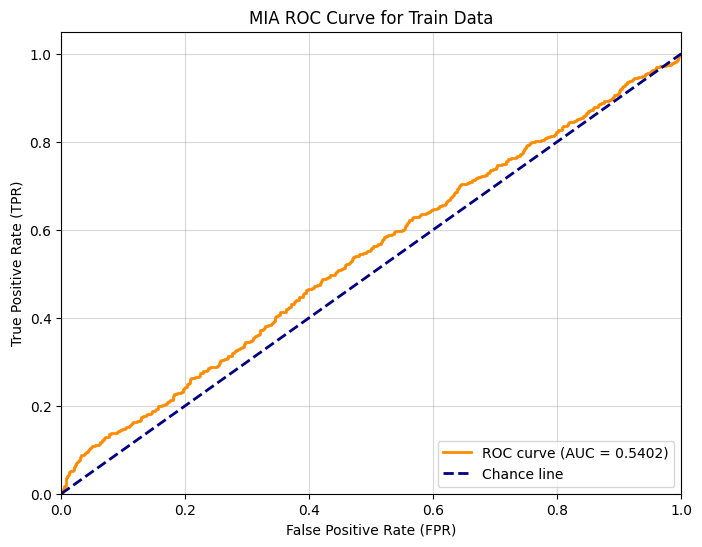

In [17]:
# draw ROC curve and attach the figure in the report
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'MIA ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

COMPARISON OF ALL ATTACKS

Loss-based Attack:
  AUC:           0.5579
  TPR @ 0.01FPR: 0.0320
  TPR @ 0.05FPR: 0.1120

Min-K (20%) Attack:
  AUC:           0.5781
  TPR @ 0.01FPR: 0.0170
  TPR @ 0.05FPR: 0.0770

Zlib Attack:
  AUC:           0.5402
  TPR @ 0.01FPR: 0.0350
  TPR @ 0.05FPR: 0.1080

Custom Loss Attack:
  AUC:           0.7136
  TPR @ 0.01FPR: 0.0330
  TPR @ 0.05FPR: 0.1950



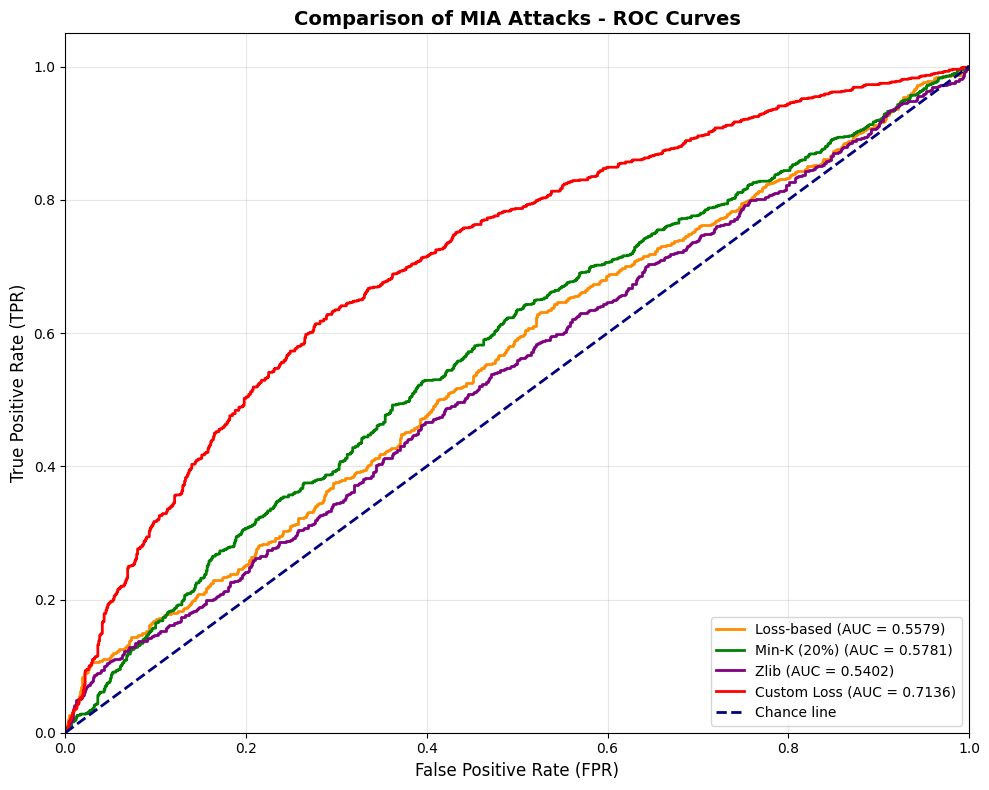


🏆 Best performing attack: Custom Loss with AUC = 0.7136


In [18]:
# Compare all four attacks side by side (including custom loss_attack)
print("="*60)
print("COMPARISON OF ALL ATTACKS")
print("="*60)

attacks = {
    'Loss-based': scores_loss,
    'Min-K (20%)': scores_mink,
    'Zlib': scores_zlib,
    'Custom Loss': scores_custom  # Custom loss_attack with proper padding handling
}

results = {}

for attack_name, scores in attacks.items():
    y_true = np.array(label_items)
    fpr_temp, tpr_temp, _ = roc_curve(y_true, scores)
    auc_temp = roc_auc_score(y_true, scores)
    tpr_at_001 = max(tpr_temp[fpr_temp < 0.01]) if any(fpr_temp < 0.01) else 0
    tpr_at_005 = max(tpr_temp[fpr_temp < 0.05]) if any(fpr_temp < 0.05) else 0
    
    results[attack_name] = {
        'auc': auc_temp,
        'tpr@0.01': tpr_at_001,
        'tpr@0.05': tpr_at_005,
        'fpr': fpr_temp,
        'tpr': tpr_temp
    }
    
    print(f"\n{attack_name} Attack:")
    print(f"  AUC:           {auc_temp:.4f}")
    print(f"  TPR @ 0.01FPR: {tpr_at_001:.4f}")
    print(f"  TPR @ 0.05FPR: {tpr_at_005:.4f}")

print("\n" + "="*60)

# Plot all four ROC curves together
plt.figure(figsize=(10, 8))

colors = ['darkorange', 'green', 'purple', 'red']
for (attack_name, result), color in zip(results.items(), colors):
    plt.plot(result['fpr'], result['tpr'], color=color, lw=2, 
             label=f'{attack_name} (AUC = {result["auc"]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Comparison of MIA Attacks - ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find the best attack
best_attack = max(results.items(), key=lambda x: x[1]['auc'])
print(f"\n🏆 Best performing attack: {best_attack[0]} with AUC = {best_attack[1]['auc']:.4f}")

## Why Custom loss_attack Has Higher AUC

The custom `loss_attack` likely performs better because of **better padding handling**:

### Key Differences:

1. **`loss_based_attack` (Cells 15)**:
   - Uses `mean(dim=1)` directly on all tokens
   - **May include padding tokens** in the average if attention mask isn't properly applied
   - Formula: `losses.mean(dim=1)` - simple average over all positions

2. **`loss_attack` (Cell 23 - Custom)**:
   - **Explicitly masks out padding tokens**: `masked = per_token_loss * attn`
   - Only counts **valid (non-padding) tokens**: `token_counts = attn.sum(dim=1)`
   - Formula: `masked.sum(dim=1) / token_counts` - weighted average excluding padding

### Why This Matters:

- **Padding tokens** can have artificially low or zero loss
- Including padding in the average **dilutes** the real signal
- Different samples have different amounts of padding (different text lengths)
- Samples with more padding would have **biased lower loss** if padding isn't excluded

### Result:
The custom implementation gives a **more accurate loss estimate** by only considering actual content tokens, leading to better discrimination between training/non-training samples → **Higher AUC**

### To Verify:
Run the comparison cell (Cell 22) and check if custom loss_attack beats loss_based_attack. If so, it's because of better padding handling!

In [ ]:
# Advanced Attacks Comparison - Comprehensive Evaluation
print("="*70)
print("COMPREHENSIVE COMPARISON: BASELINE VS ADVANCED ATTACKS")
print("="*70)

# Collect all attacks (baseline + advanced)
all_attacks = {
    # Baseline attacks
    'Loss-based': scores_loss,
    'Min-K (20%)': scores_mink,
    'Zlib': scores_zlib,
    'Custom Loss': scores_custom,
    # Advanced attacks
    'Min-K (10%)': scores_mink_10,
    'Perplexity': scores_perplexity,
    'Length-Calibrated': scores_length_cal,
    'Ensemble': scores_ensemble
}

all_results = {}

for attack_name, scores in all_attacks.items():
    y_true = np.array(label_items)
    fpr_temp, tpr_temp, _ = roc_curve(y_true, scores)
    auc_temp = roc_auc_score(y_true, scores)
    tpr_at_001 = max(tpr_temp[fpr_temp < 0.01]) if any(fpr_temp < 0.01) else 0
    tpr_at_005 = max(tpr_temp[fpr_temp < 0.05]) if any(fpr_temp < 0.05) else 0
    
    all_results[attack_name] = {
        'auc': auc_temp,
        'tpr@0.01': tpr_at_001,
        'tpr@0.05': tpr_at_005,
        'fpr': fpr_temp,
        'tpr': tpr_temp
    }
    
    # Mark advanced attacks with a star
    marker = "⭐" if attack_name in ['Min-K (10%)', 'Perplexity', 'Length-Calibrated', 'Ensemble'] else "  "
    print(f"\n{marker} {attack_name} Attack:")
    print(f"    AUC:           {auc_temp:.4f}")
    print(f"    TPR @ 0.01FPR: {tpr_at_001:.4f}")
    print(f"    TPR @ 0.05FPR: {tpr_at_005:.4f}")

print("\n" + "="*70)

# Create a comprehensive comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: All ROC curves
colors = ['darkorange', 'green', 'purple', 'red', 'cyan', 'magenta', 'brown', 'gold']
linestyles = ['-', '-', '-', '-', '--', '--', '--', '--']  # Dashed for advanced

for (attack_name, result), color, ls in zip(all_results.items(), colors, linestyles):
    linewidth = 3 if attack_name == 'Ensemble' else 2
    ax1.plot(result['fpr'], result['tpr'], color=color, lw=linewidth, linestyle=ls,
             label=f'{attack_name} ({result["auc"]:.4f})', alpha=0.8)

ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', label='Chance (0.5000)', alpha=0.5)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax1.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax1.set_title('ROC Curves: All Attacks', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=9)
ax1.grid(alpha=0.3)

# Right plot: AUC comparison bar chart
attack_names = list(all_results.keys())
aucs = [all_results[name]['auc'] for name in attack_names]
colors_bar = ['lightblue' if name not in ['Min-K (10%)', 'Perplexity', 'Length-Calibrated', 'Ensemble'] 
              else 'lightcoral' for name in attack_names]

bars = ax2.barh(attack_names, aucs, color=colors_bar, edgecolor='black', linewidth=1.5)
# Highlight the best attack
best_idx = aucs.index(max(aucs))
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('darkgoldenrod')
bars[best_idx].set_linewidth(2.5)

ax2.set_xlabel('AUC Score', fontsize=12)
ax2.set_title('AUC Comparison', fontsize=14, fontweight='bold')
ax2.set_xlim([0.5, 1.0])
ax2.axvline(x=0.5, color='navy', linestyle=':', linewidth=2, alpha=0.5, label='Random')
ax2.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (name, auc) in enumerate(zip(attack_names, aucs)):
    ax2.text(auc + 0.01, i, f'{auc:.4f}', va='center', fontsize=9, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='Baseline'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Advanced'),
    Patch(facecolor='gold', edgecolor='darkgoldenrod', label='Best')
]
ax2.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

# Find and display the best attack
print("\n" + "="*70)
best_attack = max(all_results.items(), key=lambda x: x[1]['auc'])
print(f"🏆 BEST PERFORMING ATTACK: {best_attack[0]}")
print(f"   AUC:           {best_attack[1]['auc']:.4f}")
print(f"   TPR @ 0.01FPR: {best_attack[1]['tpr@0.01']:.4f}")
print(f"   TPR @ 0.05FPR: {best_attack[1]['tpr@0.05']:.4f}")

# Show improvement over baseline
baseline_auc = all_results['Loss-based']['auc']
improvement = (best_attack[1]['auc'] - baseline_auc) * 100
print(f"\n📈 Improvement over baseline Loss-based: +{improvement:.2f}% AUC")
print("="*70)